# **TRASFORMER ENCODER ATTEMPT**


Implementation of a model inspired by the paper "A Transformer-based Framework for Multivariate Time Series Representation Learning", with some slight modifications (used Conv layers to implement the FFN in the encoder block and added some other slight modifications).


***link***: https://dl.acm.org/doi/10.1145/3447548.3467401

***Problem description***: develop a forecasting model that is able to predict several uncorrelated time series

***DATA STRUCTURE***:
Single folder containing the following files:
1. 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000
time series of length 2776.
2. 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
3. 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

---


In [1]:
# -----------------------------------* TRANSFORMER ENCODER ATTEMPT *---------------------------------------
# Implementation of a model inspired by the paper "A Transformer-based Framework for Multivariate Time Series Representation Learning",
# link: https://dl.acm.org/doi/10.1145/3447548.3467401

# Problem description: develop a forecasting model that is able to predict several uncorrelated time series

# DATA STRUCTURE:
# Single folder containing the following files:
# -> 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
# -> 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
# -> 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
# IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
# What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [2]:
# Import libraries and connect to drive personal folder

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_2/Edoardo

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import backend as K
from keras.callbacks import TensorBoard
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other support libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1KCBemE4qafe5uAlplrKNKs84tpuC_kX6/homework_2/Edoardo
2.15.0


In [3]:
# Define function for data import:

def import_data(path, zip=False):
    if zip:
        !unzip -q $path
    training_data = np.load('training_data.npy')
    valid_periods = np.load('valid_periods.npy')
    categories = np.load('categories.npy')
    return training_data, valid_periods, categories

# Call the function to import the data
training_data, valid_periods, categories = import_data('training_dataset.zip', zip=False)

# Check the shape of the data
print(training_data.shape)
print(valid_periods.shape)
print(categories.shape)

# Transform the data by extending the dimensions (number of time series, length of time series, number of features)
training_data = np.expand_dims(training_data, axis=2)

(48000, 2776)
(48000, 2)
(48000,)


# **Plotting of some time series**

---

Text(0.5, 0.98, 'First 10 time series without padding and (eventually) normalized')

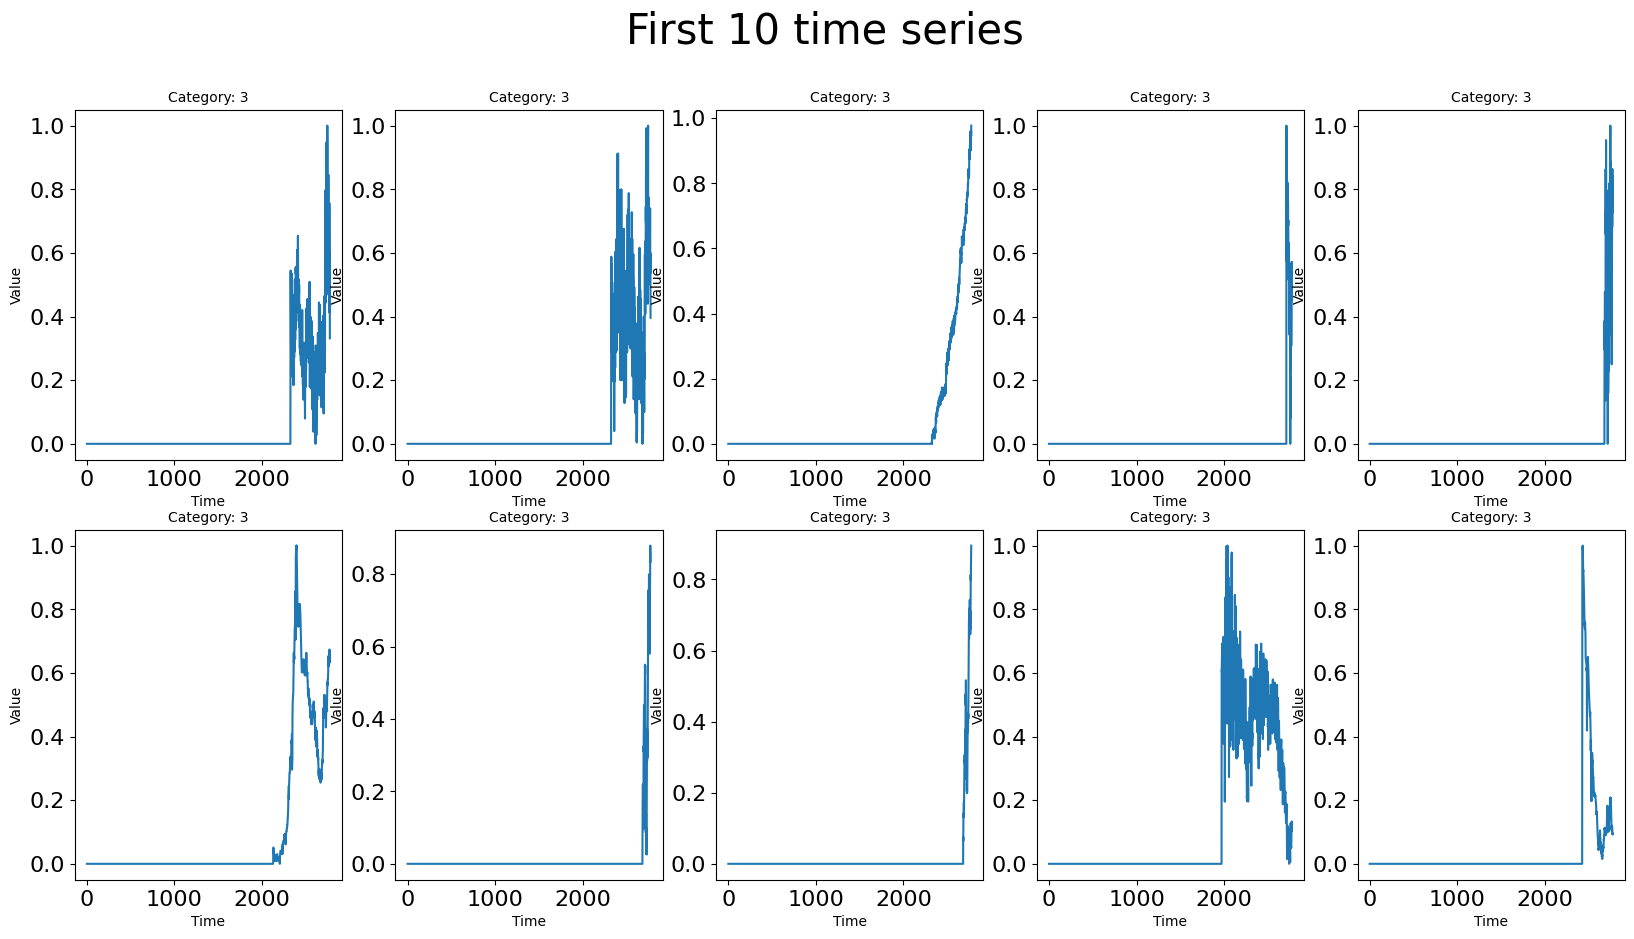

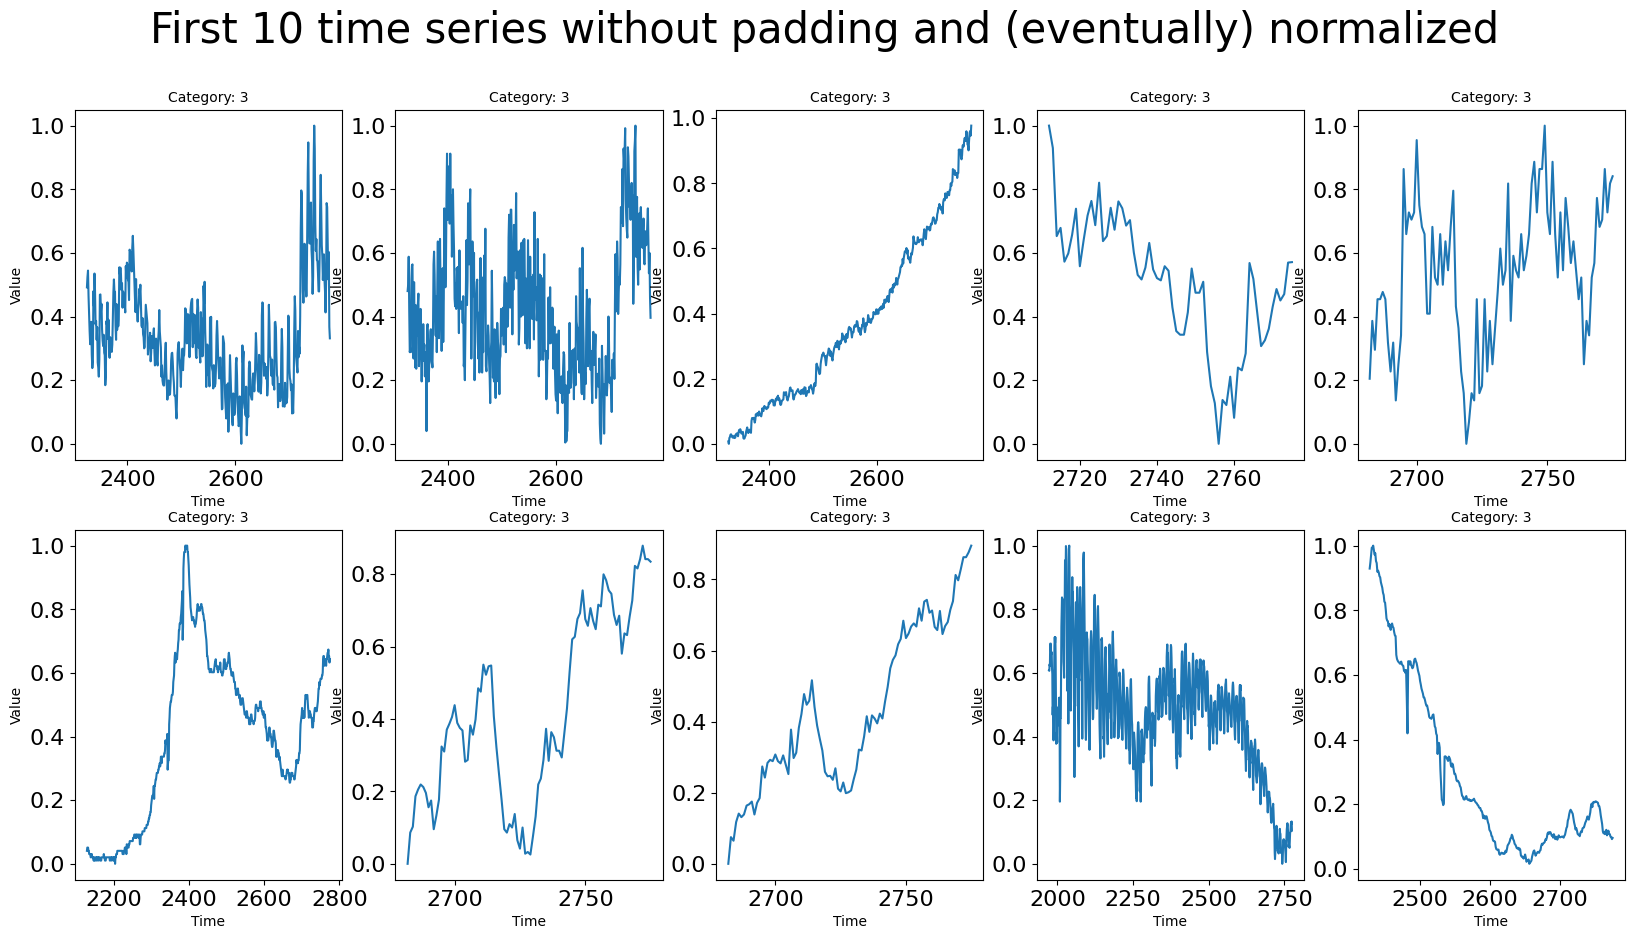

In [4]:
# -----------------------------------* DATA ANALYSIS *---------------------------------------

# Note that all the values are store as float64, so we can convert them to float32 to save memory
if training_data.dtype == np.float64:
    training_data = training_data.astype(np.float32)

# Then transform the categories into numbers
categorical_to_numerical = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5}

if categories[0] == "D":
    for category in np.unique(categories):
        categories[categories == category] = categorical_to_numerical[category]
    # To save memory, convert the categories to int32
    categories = categories.astype(np.int32)

# -<-<-<-<-<-<-<-<-<-< FIRST PLOTS AND PADDING REMOVAL/NORMALIZATION >->->->->->->->->->->-

# Plot the first 10 time series

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(training_data[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series', fontsize=30)

# -<-<-<-<-<-<-<-<-<-<-<-< DATA NORMLIZATION >->->->->->->->->->->->->-

# Define min_max normalization function
def min_max_norm(data, min, max):
    return (data - min) / (max - min)

# Apply the function over the categories singularly
def min_max_norm_by_category(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # For each category compute the min and max
        C_min = np.min(data[categories == category])
        C_max = np.max(data[categories == category])
        # Apply the min_max_norm function to the data of the current category
        data[categories == category] = min_max_norm(data[categories == category], C_min, C_max)
    return data

# Function to apply a robust scaler on each non-padded time series per category
def robust_scaler(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # Group the data by category
        data_cat = data[categories == category]
        # Compute the median and the IQR for the current category by concatenating the time series
        median = np.median(np.concatenate(data_cat))
        IQR = np.percentile(np.concatenate(data_cat), 75) - np.percentile(np.concatenate(data_cat), 25)
        # Apply the robust scaler to the data of the current category
        data[categories == category] = (data[categories == category] - median) / IQR
    return data



# -<-<-<-<-<-<-<-<-<-<  PADDING REMOVAL >->->->->->->->->->-
# Define a function to remove the padding from the time serie

def remove_padding(data, valid_periods):
    data_no_pad = []
    for i in range(data.shape[0]):
        data_no_pad.append(data[i, valid_periods[i, 0]:valid_periods[i, 1]])
    return np.array(data_no_pad)


# Remove the padding from the time series
training_data_no_pad = remove_padding(training_data, valid_periods)

#Call the function for robust scaler normalization
#training_data_no_pad = robust_scaler(training_data_no_pad, categories)

# Call the functino for min-max scaling
#training_data_no_par = min_max_norm_by_category(training_data_no_pad,categories)


# Plot the first 10 time series without padding, keeping the information about the orignal temporal location
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(range(valid_periods[i, 0], valid_periods[i, 1]), training_data_no_pad[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series without padding and (eventually) normalized', fontsize=30)

# All this samples belong to category D, and are "to be understood as not closely related to each other, but only as collected from similar data sources"
# This means that the time seies within the same categoty are to be considered as uncorrelated, but should there not be a correlation between the catoegories?



# **Some plots to analyze the data**

---


Text(0.5, 0.98, 'Partial auto-correlation')

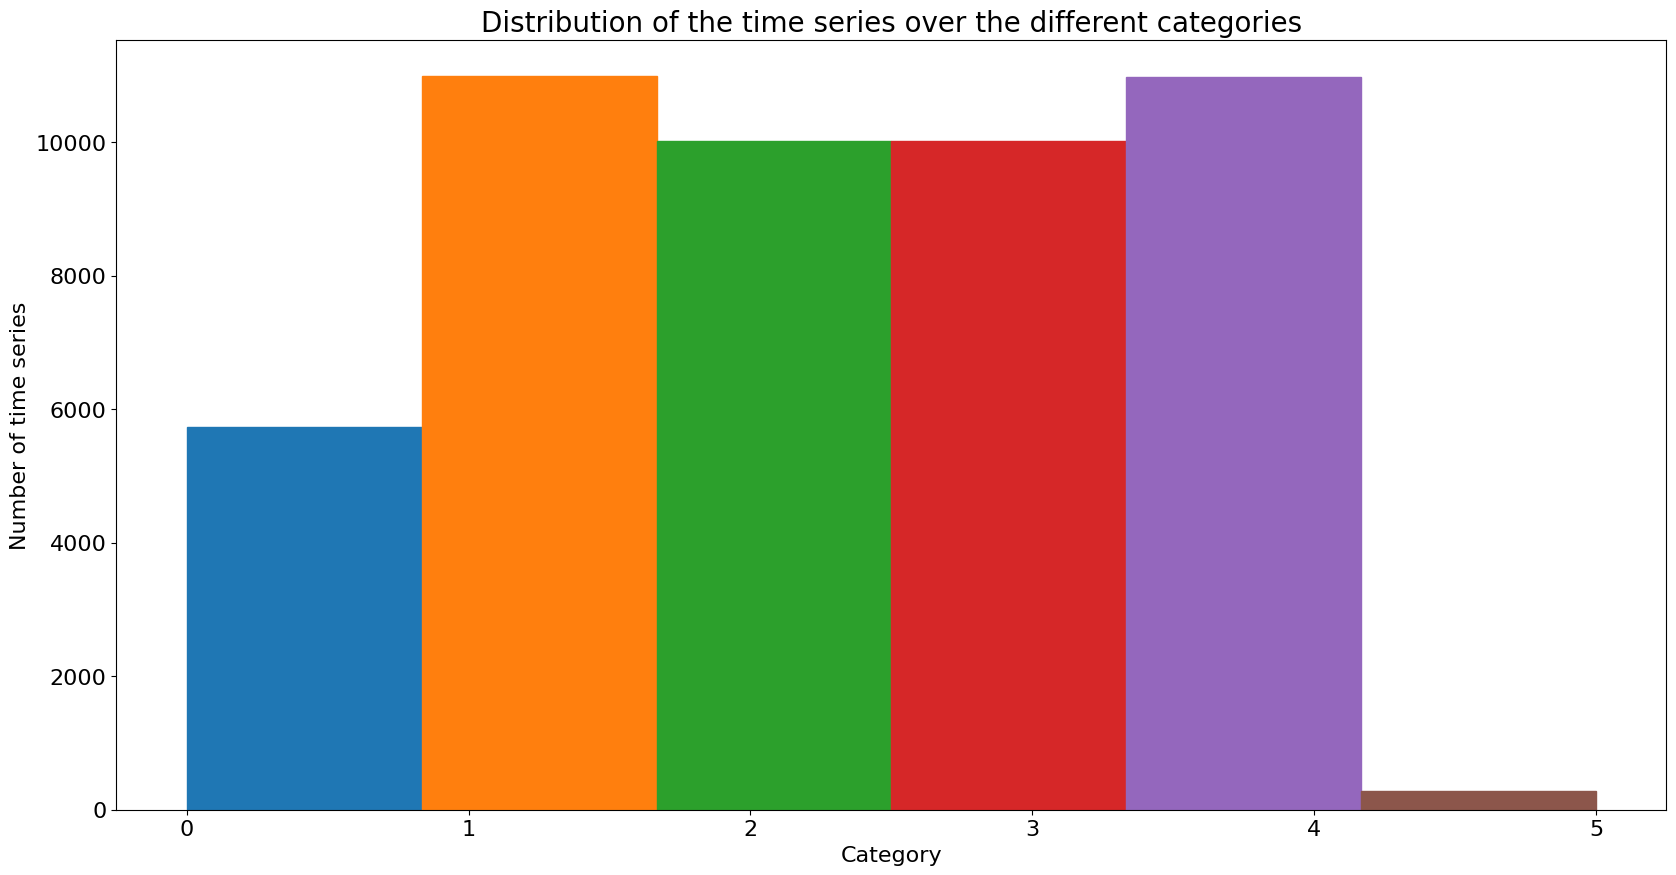

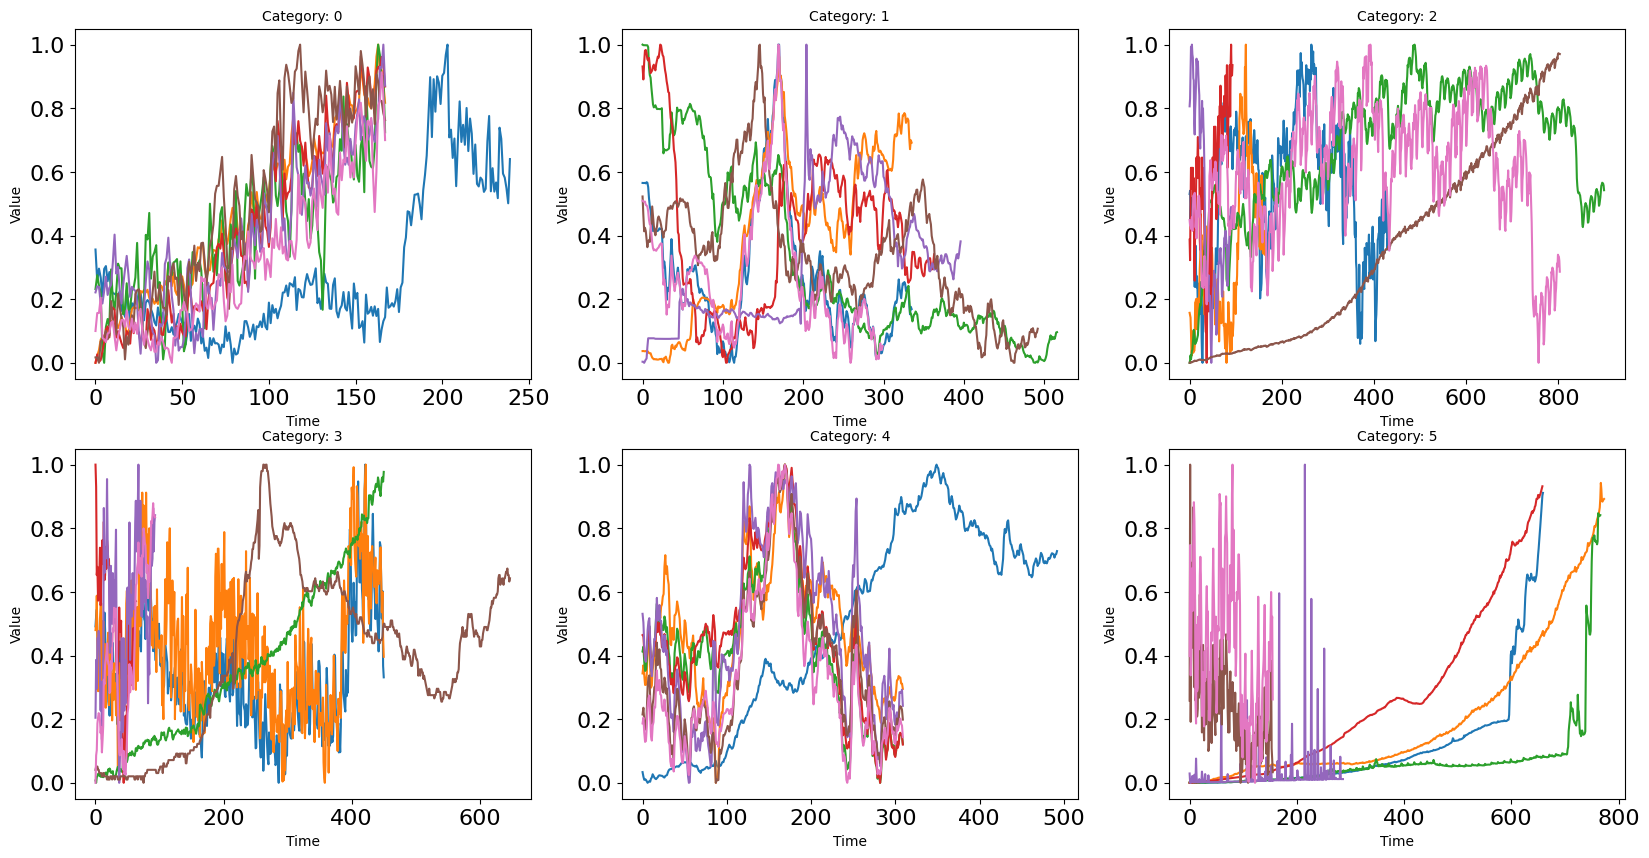

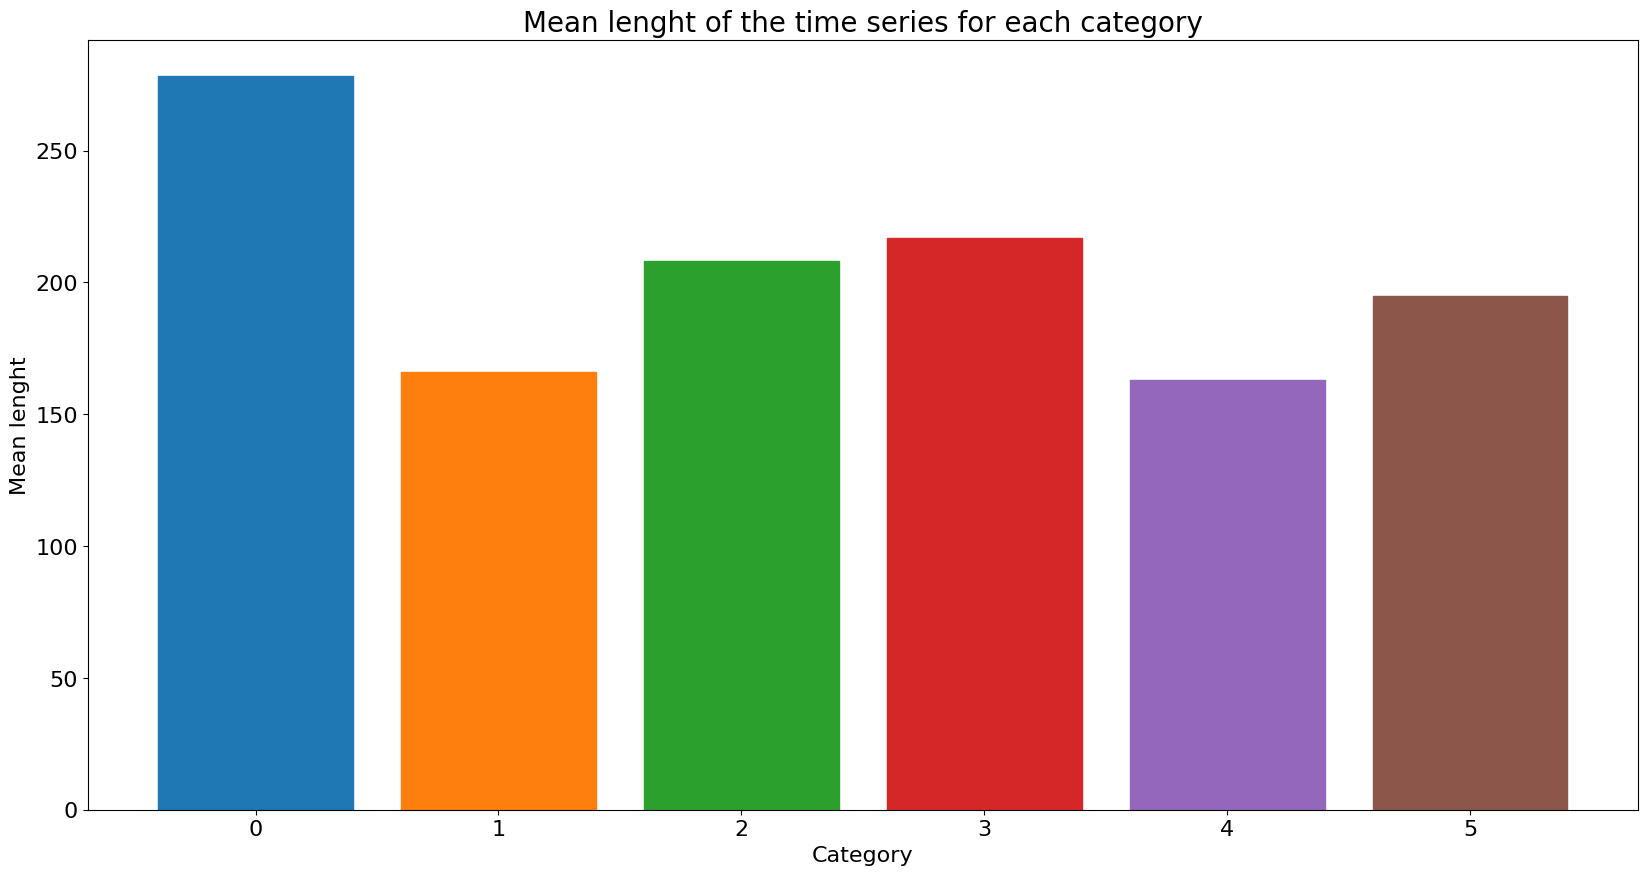

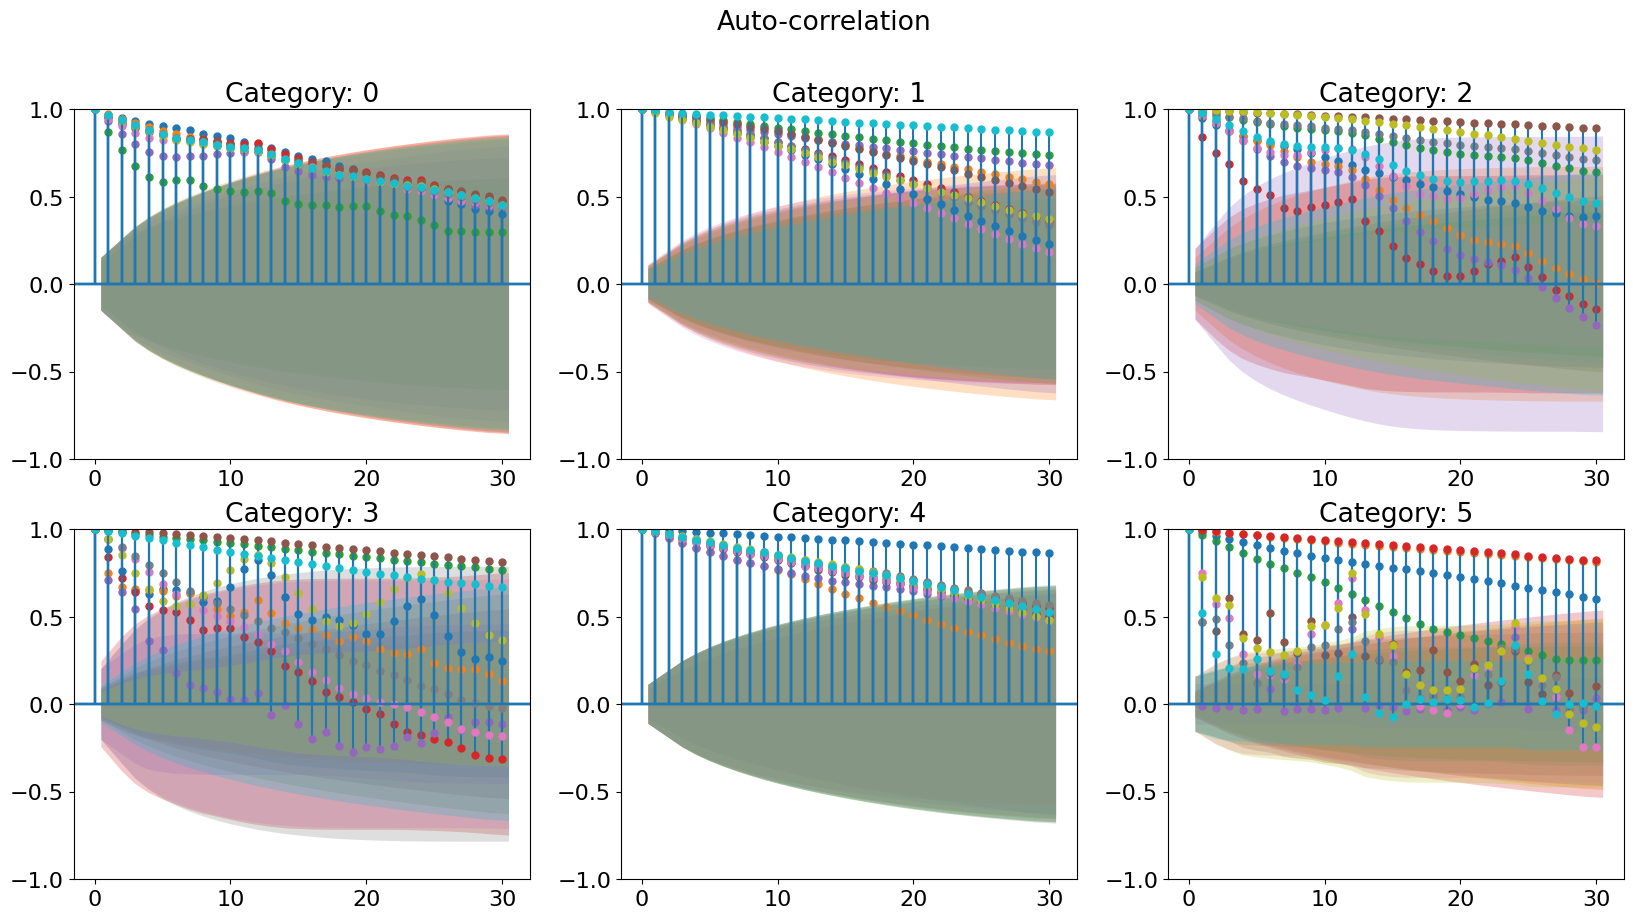

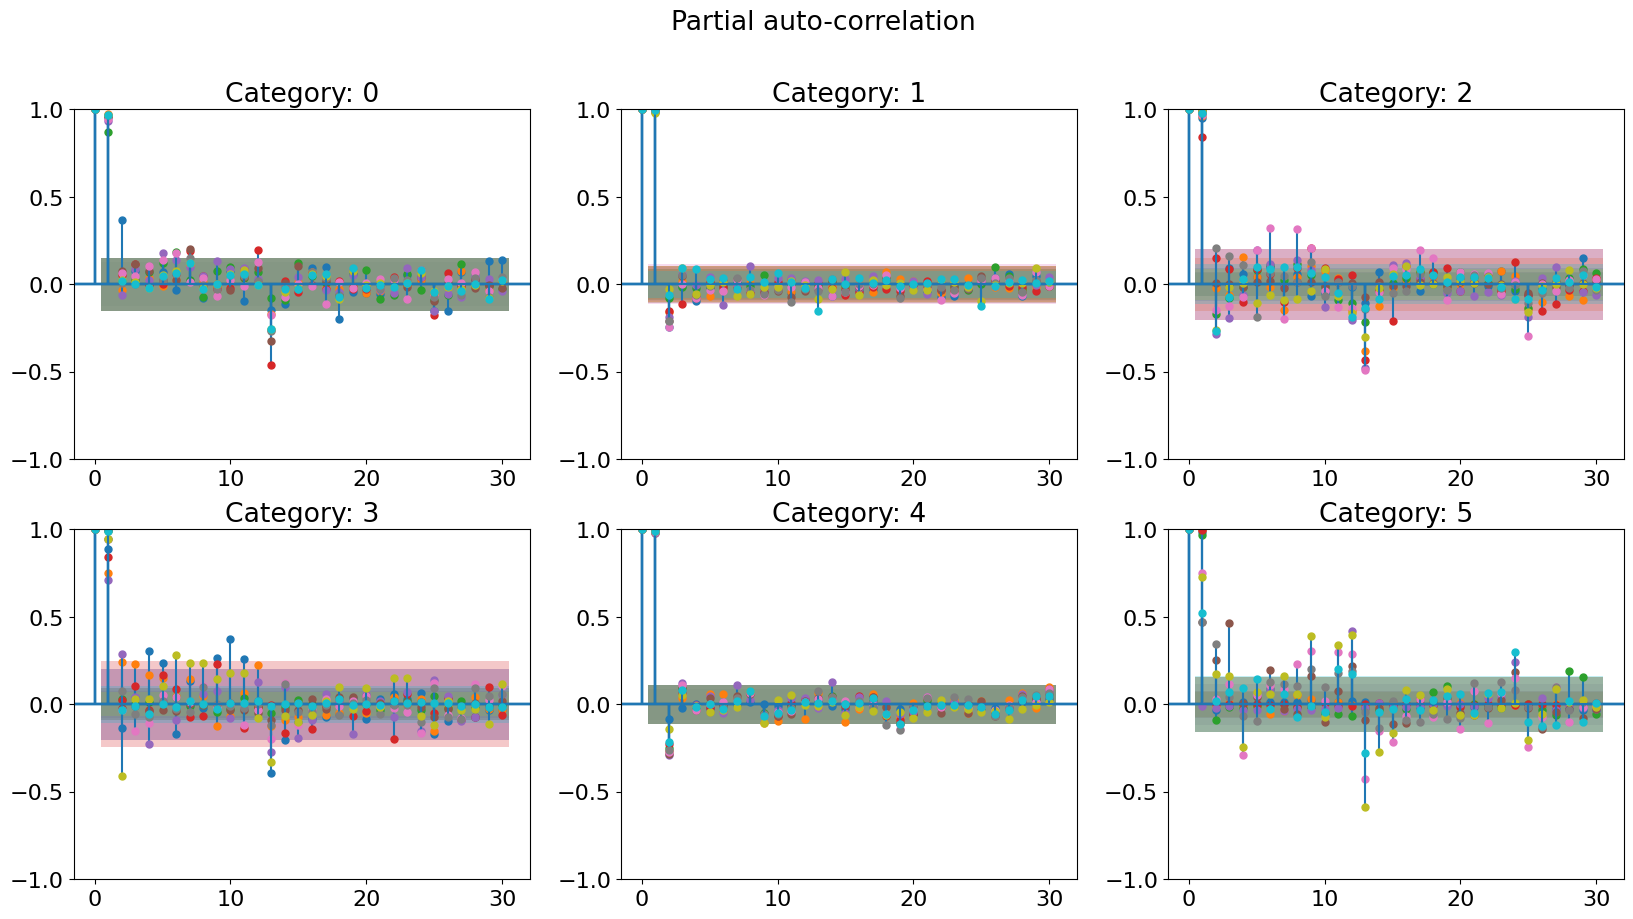

In [5]:

# -<-<-<-<-<-<-<-<-<-< DATA DISTRIBUTION ANALYSIS >->->->->->->->->->->-


# GROUP DATA BY CATEGORY:

# Transform the categories into numbers
categorical_to_numerical = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5}

if categories[0] == "D":
    for category in np.unique(categories):
        categories[categories == category] = categorical_to_numerical[category]
    # To save memory, convert the categories to int32
    categories = categories.astype(np.int32)

# Now plot the distribution of the time series over the different categories
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(categories, bins=6)
ax.set_title('Distribution of the time series over the different categories', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Number of time series')
# separate the bars and use different colors
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))
plt.xticks(np.arange(6))

# OSS: a visible imbalance between the categories is present, with category 5 been extremely underrepresented
# (category 1 is just slightly underrepresented, while the other categories are more or less equally represented)

# -<-<-<-<-<-<-< PLOT OF the FIRST TIME SERIES FOR DIFFERENT CATEGORIES >->->->->->-
# Plot the first n time series for each category (6 diffrerent plots, with multiple time series in each plot)

n = 7
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
      axs[i].plot(training_data_no_pad[categories == i][j])
    axs[i].set_title('Category: {}'.format(i), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)


# -<-<-<-<-<-<-< PLOT OF TIME SERIES BY LENGHT AND DOMAIN  >->->->->->-

# Compute mean lenght of the time series for each category and plot them in a bar plot
mean_lenght = []
for i in range(6):
    mean_lenght.append(np.mean(valid_periods[categories == i, 1] - valid_periods[categories == i, 0]))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.arange(6), mean_lenght)
ax.set_title('Mean lenght of the time series for each category', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Mean lenght')
plt.xticks(np.arange(6))
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))

# OSS: a fairly similar mean lenght for all the categories

# -<-<-<-<-<-<-<-<-<-<-< AUTO-CORRELATION  and  PARTIAL AUTO-CORRELATION PLOT >->->->->->->->->->->->->-

# Plot the auto-correlation and partial auto-correlation for the first 10 time series of each category
# The auto-correlation is computed by the function acf of the statsmodels library
# The partial auto-correlation is computed by the function pacf of the statsmodels library

n = 10
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
        plot_acf(training_data_no_pad[categories == i][j], ax=axs[i], lags=30, title='Category: {}'.format(i))
fig.suptitle('Auto-correlation')

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
        plot_pacf(training_data_no_pad[categories == i][j], ax=axs[i], lags=30, title='Category: {}'.format(i))
fig.suptitle('Partial auto-correlation')


# **Definition of some hyperparameters and dataset splitting**

---


In [6]:
# Define some Hyperparameters for the forcasting model
WINDOW_SIZE = 200
BATCH_SIZE = 512
STRIDE = 5
EPOCHS = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.03
TELESCOPE = 18
AUTOREGRESSIVE_TELESCOPE = 9
assert AUTOREGRESSIVE_TELESCOPE < TELESCOPE

# In this case, given the nature of the problem, as well as the fact that the time series are not correlated
# (so introducing some of them in training phase should now bias the test), we decide
# to make use of the great variaty of time series available, and split data among the time series themselves:

# This way, a certain percentage of the time series will be used for training (80% initial partition), while the remaining ones will be used for validation (20).
# In both case, we define the number of samples to be predicted as TELESCOPE, and the number of samples to be used for the prediction as WINDOW_SIZE.

# For the testing, we respect the imbalances among the different domains using stratify based on the categories

X_train_raw, X_test_raw, domains_train, domains_test = train_test_split(training_data_no_pad, categories, test_size=TEST_SPLIT, stratify=categories)
X_train_raw, X_val_raw, domains_train, domains_val = train_test_split(X_train_raw, domains_train, test_size=VALIDATION_SPLIT, stratify=domains_train)

In [27]:
# -----------------------------------* DATA PREPROCESSING *---------------------------------------
# Build the sequences for the forecasting model: in this case, we will try to take into account the
# imbalance between the categories usign a weighted loss function

# The function lets us build the sequences to use for the training of the forecasting model:
# In this case, given a certain domain (category), the function will build the sequences to be used for the training
# by extracting temporal windows out of each time series.
# Please note that some of the time series will takes as they are, since they are shorter than the window size.
# In some other cases, the time series are "partioned" in windows of the same size, and the last window is padded with zeros
# In any case, for the correct creation of the sequences, the dataset to be passed to the function must be the one without padding
def build_sequences_on_domain(data, categories_split  ,domain = 0, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    padding_mask = []
    masks = []
    categories = []

    temp_df = data[categories_split == domain]
    temp_label = temp_df.copy()
    # For each time series of the specific domain, compute the padding lenght
    # At the same time, generate the padding mask that should have dimension (batch_size, time_series_lenght):
    # Ideally we generate a mask for lenght = time_series_lenght + padding_lenght for each signal, then
    # we generate the padding mask during the generation of sequences using the masks previously generated
    # OSS... This is done on the data without padding
    for time_series_n in range(len(temp_df)):
        padding_len = (window + telescope) - len(temp_df[time_series_n])
        if(padding_len > 0):
            padding = np.zeros((padding_len,1), dtype='float32')
            temp_df[time_series_n] = np.concatenate((padding,temp_df[time_series_n]))
            padding = np.zeros((padding_len,1), dtype='float32')
            temp_label[time_series_n] = np.concatenate((padding,temp_label[time_series_n]))
            # Generate the padding mask
            masks.append(np.concatenate((np.zeros((padding_len), dtype='int32'), np.ones((len(temp_df[time_series_n])), dtype='int32'))))
        else:
            masks.append(np.ones((len(temp_df[time_series_n])), dtype='int32'))

    # Generate the sequences and proper padding masks
    for time_series_n in range(len(temp_df)):
          for i in np.arange(0, len(temp_df[time_series_n])-window-telescope, stride):
              dataset.append(temp_df[time_series_n][i:i+window])
              padding_mask.append(masks[time_series_n][i:i+window])
              labels.append(temp_label[time_series_n][i+window:i+window+telescope])
              categories.append(domain)

    dataset = np.array(dataset)
    labels = np.array(labels)
    padding_mask = np.array(padding_mask)
    categories = np.array(categories)
    return dataset, labels, padding_mask, categories

def inspect_multivariate(X, y, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot three sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].set_title('Sequence {}'.format(i))
        axs[i-idx].set_ylim(0,1)
    plt.show()


def inspect_multivariate_prediction(X, y, pred, telescope,categories = None, idx=None, data_to_plot= 5):

    if categories is not None:
        #Plot a single sequence for each category:
        # loop over the samples and plot one for each category
        if (idx == None):
          idx = np.random.randint(0, len(X[categories == 5]))
        figs, axs = plt.subplots(6, 1, sharex=True, figsize=(30,15))
        for i in range(6):
            axs[i].plot(np.arange(len(X[categories == i][idx])), X[categories == i][idx])
            axs[i].scatter(np.arange(len(X[categories == i][idx]), len(X[categories == i][idx])+telescope), y[categories == i][idx], color='orange')
            axs[i].scatter(np.arange(len(X[categories == i][idx]), len(X[categories == i][idx])+telescope), pred[categories == i][idx], color='green')
            axs[i].set_title('Category {}'.format(i))
            axs[i].set_ylim(0,1)
        plt.show()
    else:

        if(idx==None):
          idx=np.random.randint(0,len(X))
        # Plot data_to_plot sequences chosen based on idx
        figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
        for i in range(idx, idx+data_to_plot):
            axs[i-idx].plot(np.arange(len(X[i])), X[i])
            axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
            axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), pred[i], color='green')
            axs[i-idx].set_title('Sequence {}'.format(i))
            axs[i-idx].set_ylim(0,1)
        plt.show()

# **Generate the sequences for the training, validation and testing**


---

In [32]:
X_train, y_train, mask_train, _ = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain = 0, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
X_val, y_val, mask_val, _= build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
X_test_reg, y_test_reg, mask_test_reg, test_categories = build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
for i in range(1,6):
    X_train_temp, y_train_temp, mask_train_temp, _= build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_val_temp, y_val_temp, mask_val_temp,_ = build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_test_temp, y_test_temp, mask_test_temp,test_categories_temp= build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    # Concatenate with the previous domains
    X_train = np.concatenate((X_train, X_train_temp))
    y_train = np.concatenate((y_train, y_train_temp))
    X_val = np.concatenate((X_val, X_val_temp))
    y_val = np.concatenate((y_val, y_val_temp))
    X_test_reg = np.concatenate((X_test_reg, X_test_temp))
    y_test_reg = np.concatenate((y_test_reg, y_test_temp))
    mask_train = np.concatenate((mask_train, mask_train_temp))
    mask_val = np.concatenate((mask_val, mask_val_temp))
    mask_test_reg = np.concatenate((mask_test_reg, mask_test_temp))
    test_categories = np.concatenate((test_categories, test_categories_temp))


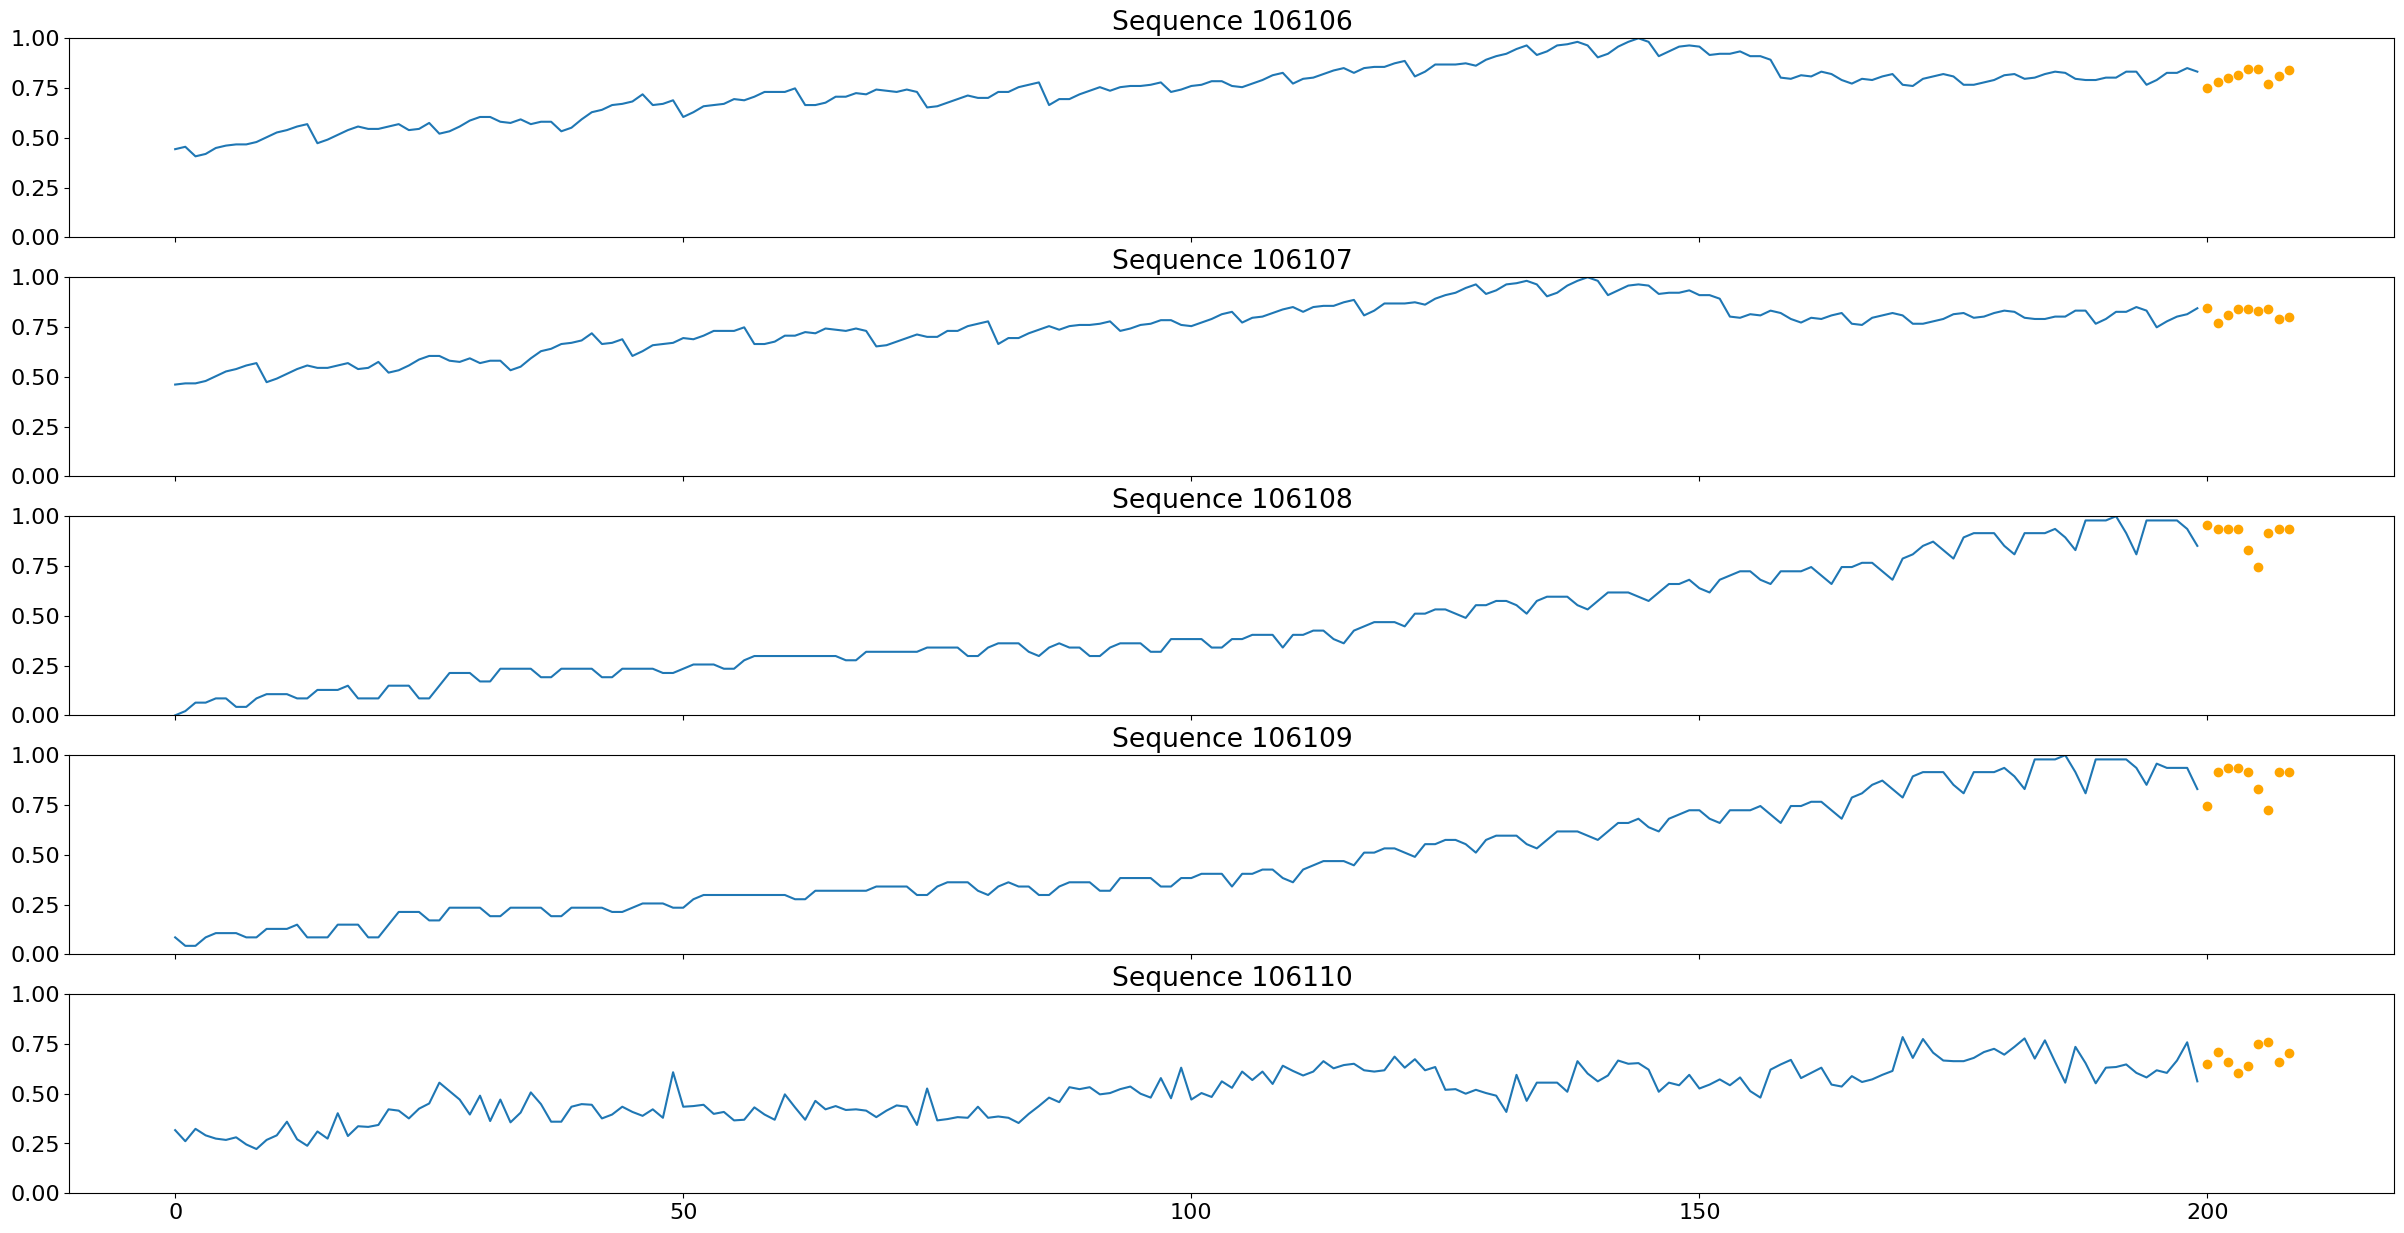

In [10]:
inspect_multivariate(X_train, y_train, AUTOREGRESSIVE_TELESCOPE)

In [ ]:
# Define input and output shape for the forecasting model

print(X_train.shape)
print(X_val.shape)
print(X_test_reg.shape)

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(362508, 200, 1)
(93276, 200, 1)
(14474, 200, 1)
(200, 1)
(9, 1)


# **FORECASTING MODEL DEFINITION**

The model is composed of a first Conv1D layer, that is used to project the input onto a d_model-dimensional space, using d_model kernels, of choosable size, where d_model is the dimension of the latent space of the input embedding.
A learnable positional embedding is added to the convolutional output before sending it into the transformer encoder, that differs form its traditional implementation for the use of Conv1D layers and Batch Normalization layers.

---

In [ ]:

# -----------------------------------* FORECASTING MODEL DEFINITION *---------------------------------------

# Define the forecasting model
# The model is composed of a first encoder, that, in our case (being a univariate prediction problem) is composed of a single Conv1D layer
# with 1 input size and d output size, where d is the number of filters (and the dimension of the latent space of the input embedding).
# Each kernel K_i (i = 1, ... , d) has a a dimension of (k,m), where 𝑘 is the width in number of time steps and m is the number of features(variables, so 1 in this case).
# Before sending the embedded input into the transformer, we add a positional encoding to the input: for this purpose, we define two different possible encodings:
# -> a fixed encoding, based on sinuosoidal functions
# -> a learned encoding, that is learned during the training phase
# Finally, the transformer is a simple CNN with batch normalization and dropout.

# -<-<-<-<-<-<-<-<-<-<-<- POSITIONAL EMBEDDING >->->->->->->->->->->->->-

class FixedPositionalEmbedding(tfkl.Layer):
    # d_model : dimension of the latent space of the input embedding
    # dropout_rate : dropout rate to be applied to the input
    # max_len : maximum lenght of the time series
    def __init__(self, d_model, dropout_rate = 0.1, max_len=200, scale_factor=1.0):
        super(FixedPositionalEmbedding, self).__init__()
        self.dropout = dropout_rate
        # Compute the positional encoding vector for the given max_len (maximul lenght of the time series)
        # for the given d_model (dimension of the latent space of the input embedding).
        # For the i-th position of the input, the positional encoding is computed as:
        pe = tf.zeros((max_len, d_model), dtype=tf.float32)
        position = tf.range(0, max_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))

        # Generate a list of tensors to assign to the pe tensor
        pe_list = []
        for i in range(d_model):
            if i % 2 == 0:
                pe_list.append(tf.sin(position * div_term[i//2]))
            else:
                pe_list.append(tf.cos(position * div_term[i//2]))
        pe = tf.stack(pe_list, axis=1)
        pe = tf.squeeze(pe)
        pe = scale_factor * tf.expand_dims(pe, axis=0)
        self.pe = tf.Variable(pe, trainable=False)

    def call(self, x):
        x = x + self.pe
        x = tfkl.Dropout(rate=self.dropout)(x)
        return x
    # A compute_mask method to convey the padding mask to the attention layer
    def compute_mask(self, inputs, mask=None):
        return mask


class LearnablePositionalEmbedding(tfkl.Layer):

    # Define the position encoding as trainable parameters
    def __init__(self, d_model,dropout_rate = 0.1, max_len=200):
        super(LearnablePositionalEmbedding, self).__init__()
        self.dropout = dropout_rate
        self.pe = tf.Variable(tf.random.uniform((1, max_len, d_model), minval=-0.02, maxval=0.02))

    def call(self, x):
        x = x + self.pe
        x = tfkl.Dropout(rate=self.dropout)(x)
        return x

    # A compute_mask method to convey the padding mask to the attention layer
    def compute_mask(self, inputs, mask=None):
        return mask

# -<-<-<-<-<-<-<-<-<-<-<- TRANSFORMER DEFINITION >->->->->->->->->->->->->-

# Define the transformer encoder layer with batch normalization instead of layer normalization
# and using a convolutional layer instead of a dense layer in the feedforward network

class TransformerEncoderLayer(tfkl.Layer):
    # d_model : dimension of the latent space of the input embedding
    # nhead : number of heads in the multihead attention mechanism
    # dim_feedforward : dimension of the feedforward network
    # dropout : dropout rate to be applied in the net
    # activation : activation function to be applied in the net
    def __init__(self, d_model, nhead = 4, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        # Define all the layers in the model
        self.self_attn = tfkl.MultiHeadAttention(nhead,d_model, dropout=dropout)
        self.dropout1 = tfkl.Dropout(rate=dropout)
        self.batch_norm1 = tfkl.BatchNormalization(epsilon=1e-5)
        self.conv1 = tfkl.Conv1D(dim_feedforward, kernel_size=5, strides=1, padding='same', activation='relu')
        self.dropout2 = tfkl.Dropout(rate=dropout)
        self.conv2 = tfkl.Conv1D(d_model, kernel_size=7, strides=1, padding='same')
        self.dropout3 = tfkl.Dropout(rate=dropout)
        self.batch_norm2 = tfkl.BatchNormalization(epsilon=1e-5)

    def call(self, embedded_output, attention_mask=None,):
        # Connect the different initialized layers:
        # embedded_output : input-encoder output to be fed to the transformer
        # attention_mask : mask to be applied to the attention layer to mask the padded positions
        src = embedded_output
        # -----* MULTIHEAD ATTENTION *-----
        # Multiheaded, self-attention mechanism
        src2 = self.self_attn(src, src, src, attention_mask=attention_mask)
        # Apply dropout
        src2 = self.dropout1(src2)
        # -----* RESIDUAL CONNECTION AND BATCH NORMALIZATION *-----
        # Residual connection
        src = src + src2
        # Apply batch normalization
        src = self.batch_norm1(src)
        # -----* FEEDFORWARD NETWORK *-----
        # Apply convolutional layer
        src2 = self.conv1(src)
        # Apply dropout
        src2 = self.dropout2(src2)
        # Apply second dense
        src2 = self.conv2(src2)
        # Apply dropout
        src2 = self.dropout3(src2)
        # Residual connection
        src = src + src2
        # Apply batch normalization
        src = self.batch_norm2(src)
        return src


# Define the transfomer decoder layer

# class TransformerDecoderLayer(tfkl.Layer):
#     # d_model : dimension of the latent space of the input embedding
#     # nhead : number of heads in the multihead attention mechanism
#     # dim_feedforward : dimension of the feedforward network
#     # dropout : dropout rate to be applied in the net
#     # activation : activation function to be applied in the net
#     def __init__(self, d_model, nhead = 4, dim_feedforward=2048, dropout=0.1, activation="relu"):
#         super(TransformerDecoderLayer, self).__init__()
#         # Define all the layers in the model
#         self.self_attn1 = tfkl.MultiHeadAttention(nhead,d_model, dropout=dropout)
#         self.self_attn2 = tfkl.MultiHeadAttention(nhead,d_model, dropout=dropout)
#         self.ffn = tfk.Sequential([tfkl.Dense(dim_feedforward, activation=activation), tfkl.Dense(d_model)])
#         self.layernorm1, self.layernorm2, self.layernorm3 = [tfkl.LayerNormalization(epsilon=1e-6) for _ in range(3)]
#         self.dropout1, self.dropout2, self.dropout3 = [tfkl.Dropout(dropout) for _ in range(3)]

#     def call(self,input ,encoder_output, training,attention_mask=None,):
#         # Connect the different initialized layers:
#         # embedded_output : input-encoder output to be fed to the transformer
#         # attention_mask : mask to be applied to the attention layer to mask the padded positions
#         causal_mask = self.get_causal_attention_mask(input)
#         padding_mask = tf.cast(attention_mask[:, tf.newaxis, :], dtype="int32") if attention_mask is not None else None
#         padding_mask = tf.minimum(padding_mask, causal_mask) if attention_mask is not None else None

#         attn_output_1 = self.att1(input, input, input, attention_mask=causal_mask)
#         attn_output_1 = self.dropout1(attn_output_1, training=training)
#         out_1 = self.layernorm1(encoder_output + attn_output_1)

#         attn_output_2 = self.att2(out_1, encoder_output, encoder_output, attention_mask=padding_mask)
#         attn_output_2 = self.dropout2(attn_output_2, training=training)
#         out_2 = self.layernorm2(out_1 + attn_output_2)

#         ffn_output = self.ffn(out_2)
#         ffn_output = self.dropout3(ffn_output, training=training)

#         return self.layernorm3(out_2 + ffn_output)

#     def get_causal_attention_mask(self, inputs):
#         batch_size, sequence_length = tf.shape(inputs)[0], tf.shape(inputs)[1]
#         i, j = tf.range(sequence_length)[:, tf.newaxis], tf.range(sequence_length)
#         mask = tf.cast(i >= j, dtype="int32")
#         return tf.tile(tf.reshape(mask, (1, sequence_length, sequence_length)), [batch_size, 1, 1])




# Generate a class to stack multiple transformer layers
class TransformerEncoderStack(tfkl.Layer):
    def __init__(self, d_model, nhead = 4, dim_feedforward=2048, dropout=0.1, activation="relu", layers=1):
        super(TransformerEncoderStack, self).__init__()
        self.layers = [TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation) for _ in range(layers)]

    def call(self, embedded_output, attention_mask=None):
        # Apply the attentoion mask to the first layer
        src = self.layers[0](embedded_output, attention_mask)
        # Apply the remaining layers
        for layer in self.layers[1:]:
            src = layer(src)
        return src

# -<-<-<-<-<-<-<-<-<-<-<- FORECASTING MODEL DEFINITION >->->->->->->->->->->->->-
def build_MVTSForecasting_model(input_shape,output_shape,fixed_positional = False ,layers=2):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "We want input time steps to be >= of output time steps"

    # Define some hyperparameters
    max_len = input_shape[0]
    d_model = 128
    nhead = 2
    dim_feedforward = 256
    dim = [128, 64]
    dropout_rate_embedder = 0.2
    dropout_rate_transformer = 0.2
    dropout_rate_dense = 0.1

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Define projector layer
    embedder = tfkl.Conv1D(d_model, kernel_size=7, strides=1, padding='same')(input_layer)

    # Define the encoder layer
    if fixed_positional:
      embedder = FixedPositionalEmbedding(d_model, dropout_rate_embedder, max_len)(embedder)
    else:
      embedder = LearnablePositionalEmbedding(d_model, dropout_rate_embedder, max_len)(embedder)

    # Proceed with the transformer layers
    transformer = TransformerEncoderStack(d_model, nhead, dim_feedforward, dropout_rate_transformer, layers=layers)(embedder, )

    #Global average pooling
    end = tfkl.GlobalAveragePooling1D(data_format="channels_first")(transformer)

    #Dense layers
    for d in dim:
        end = tfkl.Dense(d, activation='relu')(end)
        end = tfkl.Dropout(dropout_rate_dense)(end)

    #Finally, the output layer is a simple dense layer with AUTOREGRESSIVE_TELESCOPE output size
    output_layer = tfkl.Dense(output_shape[0], activation = "sigmoid",name='output_layer')(end)

    output_layer = tfkl.Reshape(output_shape)(output_layer)

    # Construct the model by connecting input and output
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='TransfomerEncoder_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model



# -----------------------------------* LR SCHEDULER  *---------------------------------------


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# Define callback for learning rate scheduler and warmup

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        tfk.backend.set_value(self.model.optimizer.lr, lr)



total_steps = len(X_train)/BATCH_SIZE *EPOCHS

warmup_steps = int(0.05*total_steps)


# Print learning rate on tensorboard: write appropriate callback

class LRTensorBoard(TensorBoard):
    # add other arguments to __init__ if you need
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

Model: "TransfomerEncoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          1024      
                                                                 
 learnable_positional_embed  (None, 200, 128)          25600     
 ding (LearnablePositionalE                                      
 mbedding)                                                       
                                                                 
 transformer_encoder_stack   (None, 200, 128)          1053184   
 (TransformerEncoderStack)                                       
                                                                 
 global_average_pooling1d (  (None, 200)               0         
 GlobalAveragePooling1D)                   

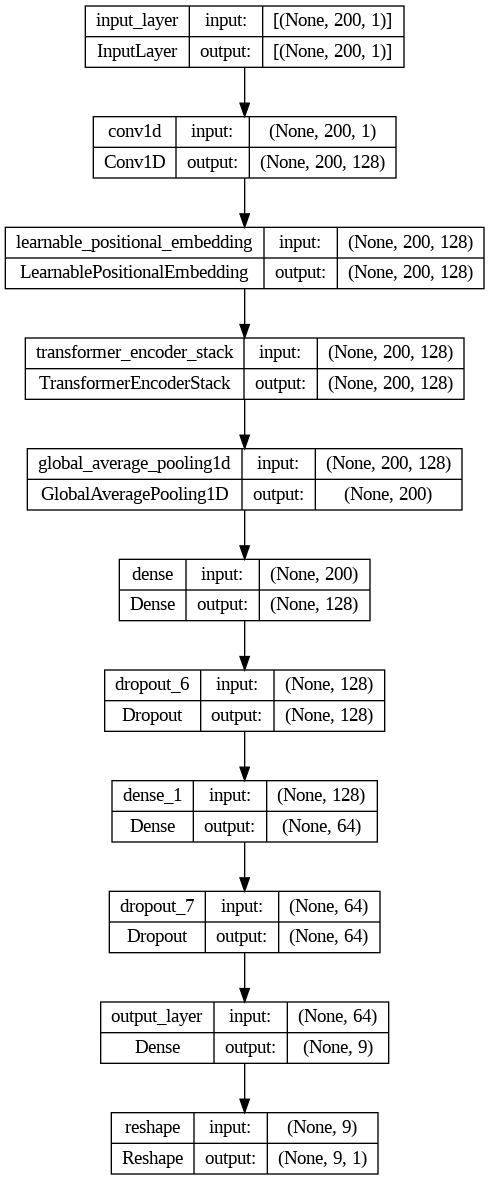

In [ ]:
model = build_MVTSForecasting_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.00005, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-6)
    ]
).history

Epoch 1/100
709/709 [==============================] - 98s 120ms/step - loss: 0.0088 - val_loss: 0.0077 - lr: 0.0010
Epoch 2/100
709/709 [==============================] - 84s 118ms/step - loss: 0.0068 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/100
709/709 [==============================] - 88s 124ms/step - loss: 0.0065 - val_loss: 0.0061 - lr: 0.0010
Epoch 4/100
709/709 [==============================] - 83s 118ms/step - loss: 0.0063 - val_loss: 0.0059 - lr: 0.0010
Epoch 5/100
709/709 [==============================] - 88s 124ms/step - loss: 0.0062 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/100
709/709 [==============================] - 88s 124ms/step - loss: 0.0061 - val_loss: 0.0064 - lr: 0.0010
Epoch 7/100
709/709 [==============================] - 84s 118ms/step - loss: 0.0060 - val_loss: 0.0063 - lr: 0.0010
Epoch 8/100
709/709 [==============================] - 83s 118ms/step - loss: 0.0060 - val_loss: 0.0073 - lr: 0.0010
Epoch 9/100
709/709 [==============================] - 84s 118ms

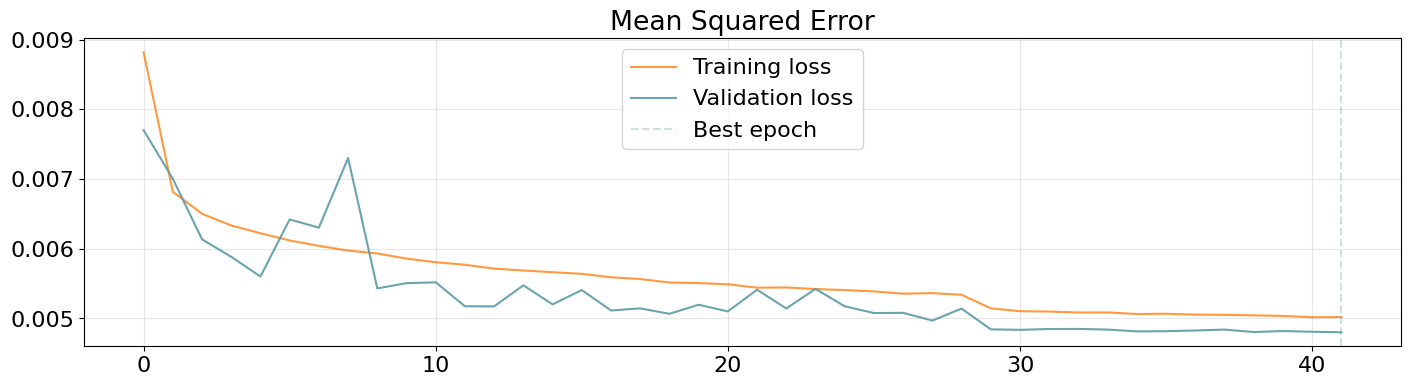

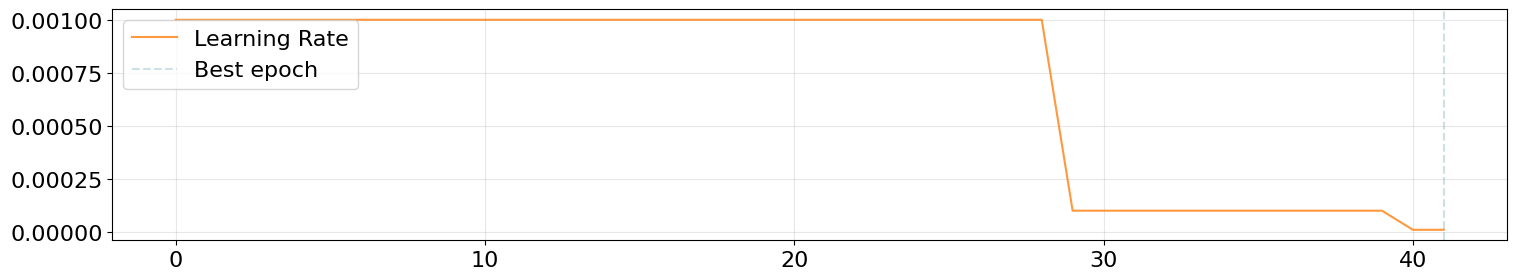

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


model.save('Sixth_Attempt/secondTry/SixthAttempt')

In [ ]:
del model

In [11]:
model = tfk.models.load_model('Sixth_Attempt/secondTry/SixthAttempt')
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,TELESCOPE,AUTOREGRESSIVE_TELESCOPE):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,AUTOREGRESSIVE_TELESCOPE:],pred_temp), axis=1)


In [12]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (14474, 18, 1)
Mean Squared Error: 0.007200674153864384
Mean Absolute Error: 0.05275188758969307


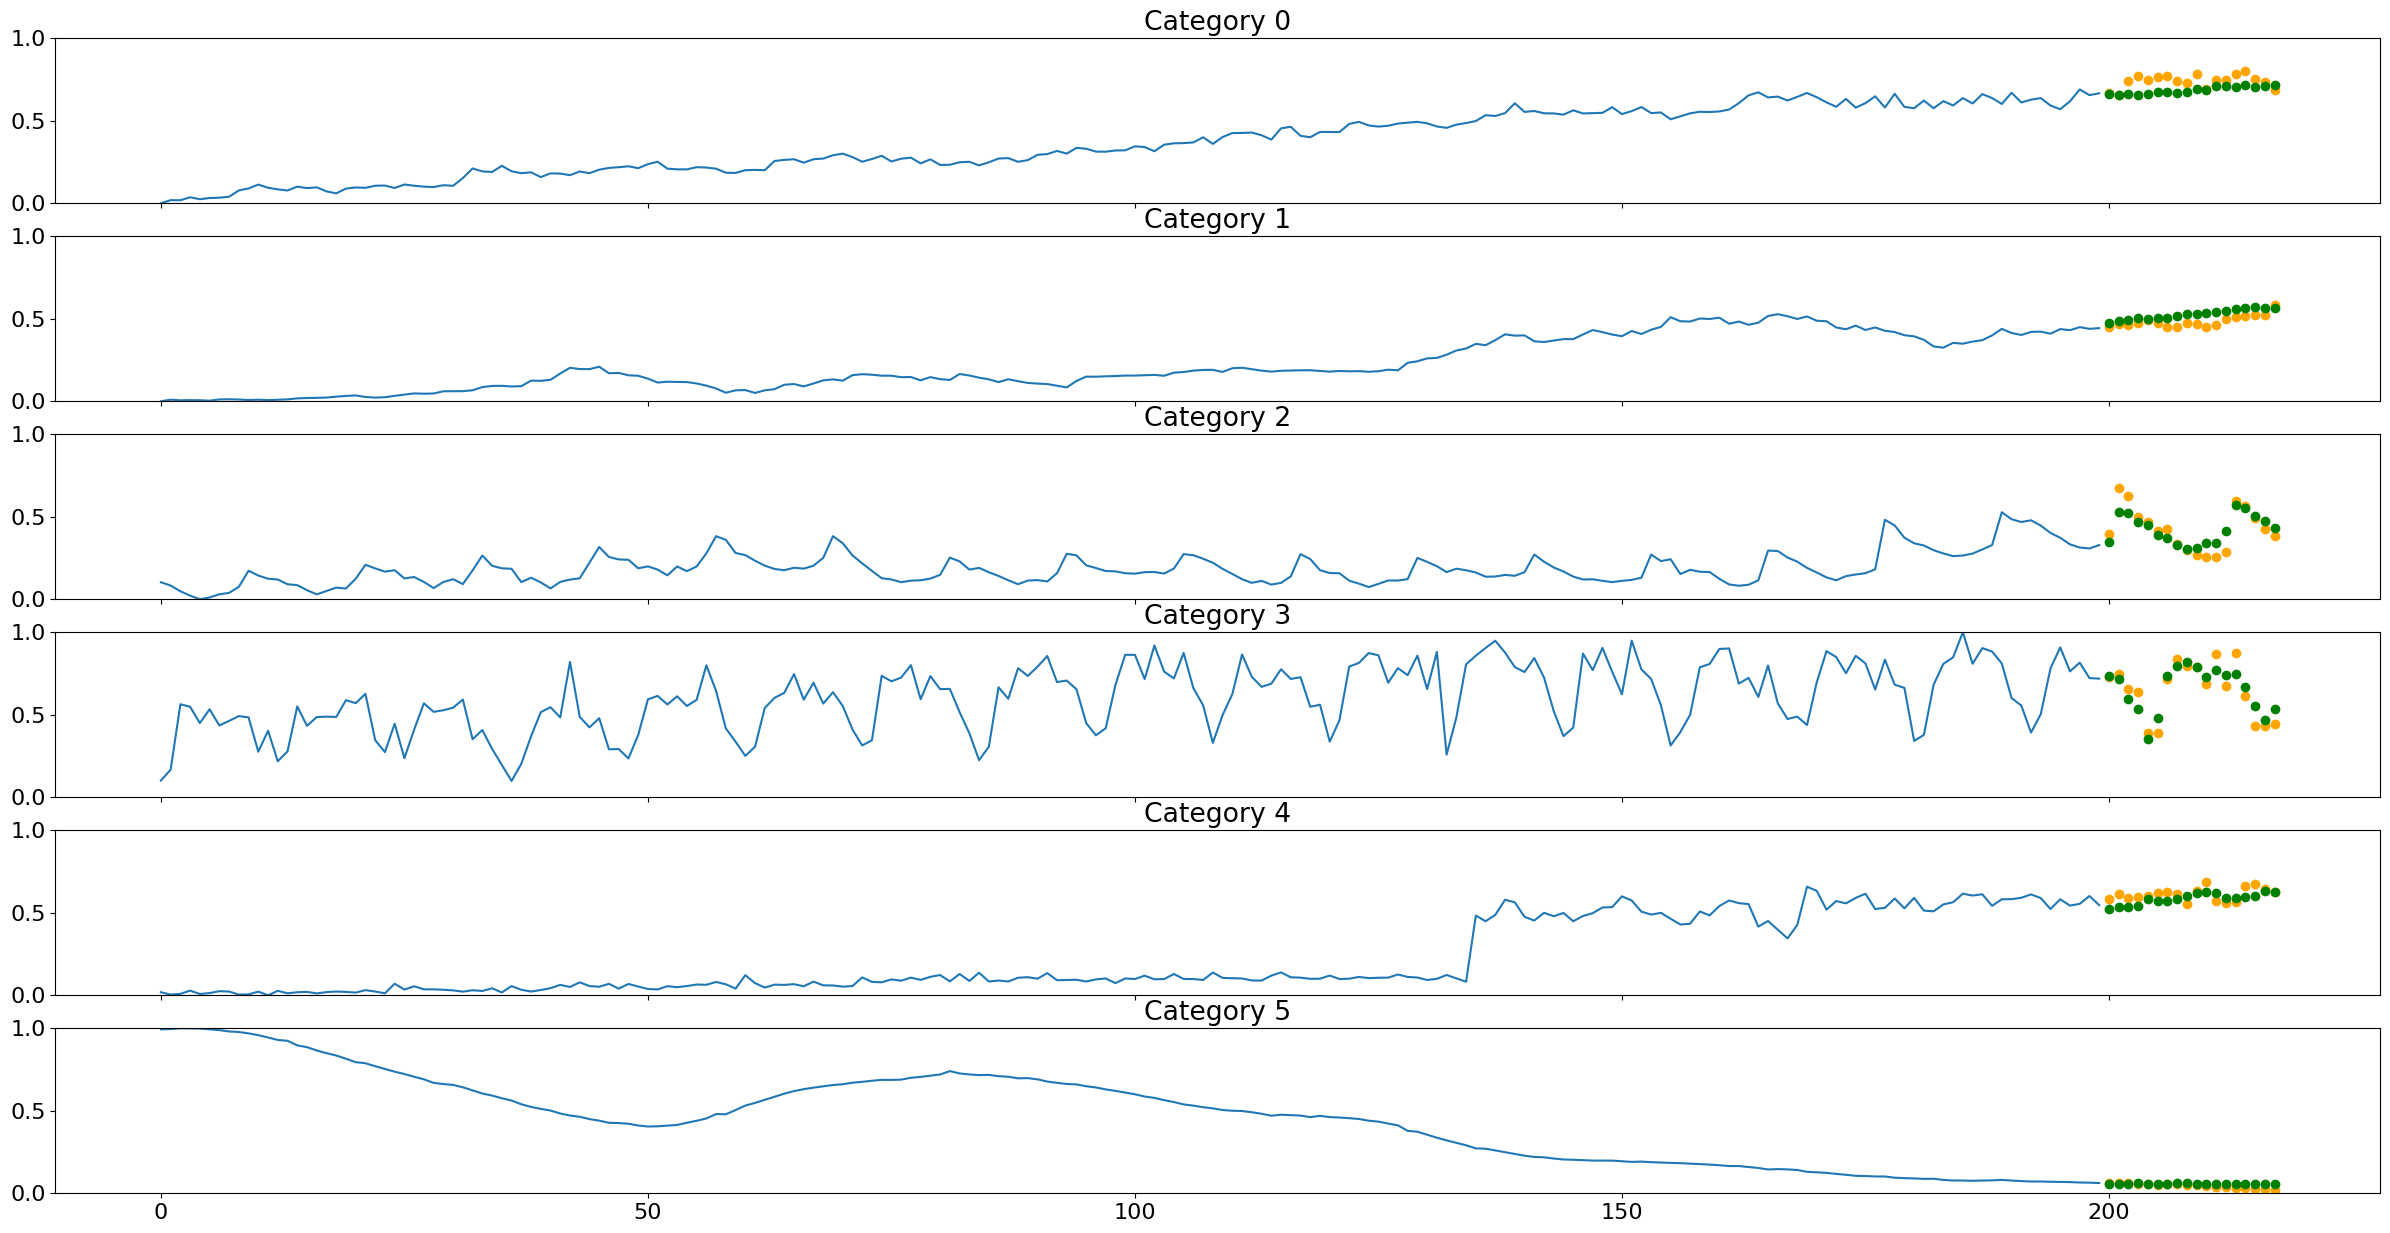

In [34]:
inspect_multivariate_prediction(X_test_reg, y_test_reg,reg_predictions, TELESCOPE, test_categories)